# Chapter 6 Lab 2

## Goal
In this lab, we will walk through applying Fuzzy C-Means for clustering players in the DoTalicious data set. There are functions available for installation to perform Fuzzy C-Means outside of sklearn. For example, there is scikit-fda - which must be installed apart from scikit. There is also skfuzzy aka scikit fuzzy. However, for our purposes in this lab, these are too complicated. Below, we've imported "fuzzy-c-means" which is available through PiPy and much simpler to use. 

## Brief Refresher
Fuzzy C-Means extends K-Means by allowing data points to have membership in more than on cluster. The algorithm returns a "percentage" - almost a likelihood - that a data point belongs to a certain group. For example, one point might be assigned 40% to Cluster 1 and 60% to Cluster 2. In this case, you'd lean toward it being part of Cluster 2.

## Preparation

First, uncomment the line below if you have not installed fuzzy-c-means and then import packages once installed.

In [4]:
#! pip install fuzzy-c-means

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from fcmeans import FCM
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
import os

import warnings
warnings.filterwarnings('ignore')


## Step 1: Data Pre-processing

Let's read in the data and take a quick look at it.

In [6]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
#dota_df1.set_index('PlayerID', inplace=True)
dota_df1.drop(['PlayerID'], axis=1, inplace=True)
dota_df1.head()


,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,1,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780
1,66,39,0,0,989.882,1,373,0.13,450,745,4484,518,455,49,23,169800
2,3,0,0,0,1000.000,0,11,0.11,28,18,186,10,7,0,0,6180
3,100,59,5,1,1228.460,1,1079,0.26,448,934,13943,1885,1417,132,36,250200
4,1,1,0,0,1020.000,0,9,0.28,2,10,38,8,3,0,0,1944


In [7]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       868 non-null    int64  
 1   GamesWon          868 non-null    int64  
 2   GamesLeft         868 non-null    int64  
 3   Ditches           868 non-null    int64  
 4   Points            868 non-null    float64
 5   SkillLevel        868 non-null    object 
 6   Kills             868 non-null    int64  
 7   KillsPerMin       868 non-null    float64
 8    Deaths           868 non-null    int64  
 9   Assists           868 non-null    int64  
 10  CreepsKilled      868 non-null    int64  
 11  CreepsDenied      868 non-null    int64  
 12   NeutralsKilled   868 non-null    int64  
 13   TowersDestroyed  868 non-null    int64  
 14   RaxsDestroyed    868 non-null    int64  
 15   TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory u

Notice that we will need to change some data types.

In [8]:
dota_df1[' TotalTime'] = pd.to_numeric(dota_df1[' TotalTime'], errors="coerce")

We'll make a quick fix to an odd value in SkillLevel too. I've randomly chosen to make it a 1.

In [9]:
dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

Lastly, let's work on the SkillLevel column!

In [10]:
dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GamesPlayed       868 non-null    int64   
 1   GamesWon          868 non-null    int64   
 2   GamesLeft         868 non-null    int64   
 3   Ditches           868 non-null    int64   
 4   Points            868 non-null    float64 
 5   SkillLevel        868 non-null    category
 6   Kills             868 non-null    int64   
 7   KillsPerMin       868 non-null    float64 
 8    Deaths           868 non-null    int64   
 9   Assists           868 non-null    int64   
 10  CreepsKilled      868 non-null    int64   
 11  CreepsDenied      868 non-null    int64   
 12   NeutralsKilled   868 non-null    int64   
 13   TowersDestroyed  868 non-null    int64   
 14   RaxsDestroyed    868 non-null    int64   
 15   TotalTime        867 non-null    float64 
dtypes: category(1), float64(3)

In [11]:
dota_df1['SkillLevel'] = dota_df1['SkillLevel'].cat.rename_categories({'0':'N', '1':'B', '2':'I', '3':'A'})
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,B,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780.0
1,66,39,0,0,989.882,B,373,0.13,450,745,4484,518,455,49,23,169800.0
2,3,0,0,0,1000.000,N,11,0.11,28,18,186,10,7,0,0,6180.0
3,100,59,5,1,1228.460,B,1079,0.26,448,934,13943,1885,1417,132,36,250200.0
4,1,1,0,0,1020.000,N,9,0.28,2,10,38,8,3,0,0,1944.0


Next, let's check for null values and remove those.

In [12]:
dota_df1.isna().sum().sum()

1

In [13]:
dota_df1[dota_df1.isnull().any(axis=1)]

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
517,0,0,0,0,1000.0,N,0,0.0,0,0,0,0,0,0,0,NaN


In [14]:
dota_df1.drop([517], inplace=True)

In [15]:
dota_df1.isna().sum().sum()

0

Also, since SkillLevel is categorical, sklearn dbscan cannot use it. We will copy it into a dataframe of its own (which will come in handy for us at the end of the lab).

In [16]:
dota_level = pd.DataFrame(dota_df1['SkillLevel']) # We're going to use this at the end of the lab!
dota_df1.drop(['SkillLevel'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780.0
1,66,39,0,0,989.882,373,0.13,450,745,4484,518,455,49,23,169800.0
2,3,0,0,0,1000.000,11,0.11,28,18,186,10,7,0,0,6180.0
3,100,59,5,1,1228.460,1079,0.26,448,934,13943,1885,1417,132,36,250200.0
4,1,1,0,0,1020.000,9,0.28,2,10,38,8,3,0,0,1944.0


In [17]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 0 to 867
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       867 non-null    int64  
 1   GamesWon          867 non-null    int64  
 2   GamesLeft         867 non-null    int64  
 3   Ditches           867 non-null    int64  
 4   Points            867 non-null    float64
 5   Kills             867 non-null    int64  
 6   KillsPerMin       867 non-null    float64
 7    Deaths           867 non-null    int64  
 8   Assists           867 non-null    int64  
 9   CreepsKilled      867 non-null    int64  
 10  CreepsDenied      867 non-null    int64  
 11   NeutralsKilled   867 non-null    int64  
 12   TowersDestroyed  867 non-null    int64  
 13   RaxsDestroyed    867 non-null    int64  
 14   TotalTime        867 non-null    float64
dtypes: float64(3), int64(12)
memory usage: 108.4 KB


Now that we've got some nice data, let's scale it.

Also, let's get rid of some of the leading spaces in the columns names.

In [18]:
scaler = StandardScaler()
dota_df2 = pd.DataFrame(scaler.fit_transform(dota_df1), columns = dota_df1.columns)

dota_df2 = dota_df2.rename(columns=lambda x: x.strip())
dota_df2

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,1.726192,1.707709,1.343489,2.925072,0.805092,1.106833,-0.179345,1.116715,1.457369,1.571490,1.173404,0.740012,1.616977,1.625071,1.871061
1,-0.128221,-0.098239,-0.509820,-0.393625,-0.208189,-0.156910,-0.027349,-0.079019,-0.092739,-0.159318,-0.078688,-0.271179,-0.123951,-0.090333,-0.123286
2,-0.434856,-0.435234,-0.509820,-0.393625,-0.123792,-0.397940,-0.331341,-0.429678,-0.418818,-0.376502,-0.329107,-0.422133,-0.402727,-0.398570,-0.467871
3,0.037265,0.074579,1.034604,0.159491,1.781855,0.313165,1.948600,-0.080680,-0.007967,0.318661,0.595174,0.052969,0.348262,0.083887,0.046037
4,-0.444591,-0.426593,-0.509820,-0.393625,0.043034,-0.399271,2.252592,-0.451283,-0.422406,-0.383981,-0.330093,-0.423481,-0.402727,-0.398570,-0.476792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.401935,0.428639,-0.447959,-0.423303,-0.382111,-0.330586,-0.419100,-0.402727,-0.398570,-0.476899
863,-0.332644,-0.357466,-0.200936,-0.393625,-0.753041,-0.342010,-0.635333,-0.300882,-0.347054,-0.321928,-0.271432,-0.294091,-0.345834,-0.371767,-0.350987
864,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.404598,-1.395313,-0.448790,-0.426443,-0.384992,-0.333543,-0.424491,-0.402727,-0.398570,-0.477371
865,0.061601,0.221474,-0.200936,0.159491,1.076935,0.558856,3.164568,0.107114,0.089363,0.153523,0.125393,0.030730,0.371019,0.271510,0.056272


## Step 2: Run Fuzzy C-Means

Now let's run fuzzy c-means with K =5, as we found the optimal K in Lab 1.

We will convert our dataframe into an array to avoid issues with fuzzy-c-means.

In [19]:
dota_np = dota_df2.to_numpy()
dota_np

array([[ 1.7261924 ,  1.70770914,  1.34348913, ...,  1.61697661,
         1.62507087,  1.87106115],
       [-0.12822082, -0.09823917, -0.50982046, ..., -0.12395073,
        -0.09033324, -0.12328574],
       [-0.43485607, -0.43523431, -0.50982046, ..., -0.40272668,
        -0.39856992, -0.46787067],
       ...,
       [-0.44459053, -0.43523431, -0.50982046, ..., -0.40272668,
        -0.39856992, -0.47737086],
       [ 0.06160101,  0.22147417, -0.20093553, ...,  0.37101881,
         0.27150981,  0.05627245],
       [-0.44459053, -0.42659341, -0.50982046, ..., -0.40272668,
        -0.38516832, -0.47676223]])

In [20]:
selected_K = 5
fcm = FCM(n_clusters=selected_K, max_iter=10, random_state=2063)
fcm.fit(dota_np)

Once we've fit the model, let's let it tell us the cluster to which they most likely belong. 

Like other clustering packages, "predict" produces the same output as the "labels_" attribute. You can see the labels below. 

In [21]:
fcm_centers = fcm.centers
fcm_labels = fcm.predict(dota_np)
fcm_labels

array([1, 0, 4, 3, 0, 0, 4, 0, 0, 3, 3, 0, 3, 0, 1, 4, 4, 1, 3, 0, 0, 1,
       0, 3, 0, 0, 4, 4, 0, 4, 4, 3, 4, 0, 0, 4, 0, 0, 0, 4, 0, 0, 4, 0,
       3, 0, 3, 0, 0, 4, 4, 3, 4, 0, 0, 3, 1, 3, 4, 1, 3, 3, 0, 0, 0, 3,
       0, 0, 3, 0, 3, 0, 4, 4, 3, 0, 4, 3, 4, 4, 1, 4, 4, 3, 4, 0, 2, 1,
       4, 4, 0, 1, 3, 1, 0, 0, 3, 4, 0, 0, 1, 0, 4, 4, 4, 0, 0, 4, 2, 3,
       4, 3, 1, 3, 0, 0, 4, 1, 3, 0, 3, 0, 0, 2, 0, 1, 0, 0, 1, 1, 4, 1,
       4, 4, 0, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 3, 2, 4, 1, 4, 2, 4, 4, 3, 0, 0, 4, 1, 0, 0, 4, 4,
       4, 1, 0, 0, 3, 4, 4, 4, 4, 4, 3, 3, 2, 0, 4, 4, 3, 2, 1, 1, 3, 4,
       0, 4, 0, 4, 4, 0, 4, 0, 0, 0, 3, 3, 4, 0, 4, 3, 0, 4, 4, 1, 2, 0,
       3, 0, 4, 4, 4, 4, 0, 4, 1, 3, 0, 4, 4, 2, 4, 3, 4, 3, 2, 0, 4, 3,
       0, 4, 0, 4, 1, 4, 4, 0, 0, 4, 4, 0, 4, 4, 0, 3, 0, 4, 0, 0, 1, 4,
       0, 0, 0, 4, 1, 4, 0, 4, 0, 4, 4, 0, 1, 4, 4, 2, 1, 0, 4, 4, 0, 0,
       3, 3, 1, 4, 3, 4, 4, 4, 0, 4, 0, 0, 0, 0, 3,

Note one thing from the above output: the first point belongs in Cluster 1, the second (moving to the right) belongs in Cluster 0.

If we use "soft_predict" and print the output, we'll see each data point as a row with 5 columns (since we specified 5 clusters) and the "percentage" assigned to each data point as a possible member of that cluster. 

So, the first data point above was assigned to Cluster 1 so it should have the highest "percentage" in the second column (remembering Python numbering starts at 0 not 1!) and the second row should see the highest in the first column (Cluster 0).

Sure enough! That is what we see.

In [22]:
fcm_soft = fcm.soft_predict(dota_np)
fcm_soft

array([[0.09355504, 0.50646961, 0.15091905, 0.16044684, 0.08860946],
       [0.52888561, 0.02107207, 0.00314399, 0.15365414, 0.29324419],
       [0.28002282, 0.00849911, 0.00156276, 0.04149419, 0.66842112],
       ...,
       [0.09627627, 0.01194438, 0.00237776, 0.04135556, 0.84804603],
       [0.25304154, 0.18524038, 0.02941323, 0.39291407, 0.13939078],
       [0.51545441, 0.05969094, 0.01185997, 0.23456396, 0.17843072]])

Let's do a quick count of cluster membership. In some ways, this is meaningless since data points are allowed to have membership in more than one cluster. This code would count the cluster with the highest "percentage" assigned in each case - using the output from "predict" not "soft_predict" in other words.

The counts do differ slightly from Lab 1.

In [23]:
k_labels = pd.DataFrame(fcm_labels)
k_labels[0].value_counts()

4    358
0    276
3    122
1     79
2     32
Name: 0, dtype: int64

Below, we'll add the labels as a column to our dataframe.

In [24]:
dota_df2['cluster'] = fcm_labels
dota_df2

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime,cluster
0,1.726192,1.707709,1.343489,2.925072,0.805092,1.106833,-0.179345,1.116715,1.457369,1.571490,1.173404,0.740012,1.616977,1.625071,1.871061,1
1,-0.128221,-0.098239,-0.509820,-0.393625,-0.208189,-0.156910,-0.027349,-0.079019,-0.092739,-0.159318,-0.078688,-0.271179,-0.123951,-0.090333,-0.123286,0
2,-0.434856,-0.435234,-0.509820,-0.393625,-0.123792,-0.397940,-0.331341,-0.429678,-0.418818,-0.376502,-0.329107,-0.422133,-0.402727,-0.398570,-0.467871,4
3,0.037265,0.074579,1.034604,0.159491,1.781855,0.313165,1.948600,-0.080680,-0.007967,0.318661,0.595174,0.052969,0.348262,0.083887,0.046037,3
4,-0.444591,-0.426593,-0.509820,-0.393625,0.043034,-0.399271,2.252592,-0.451283,-0.422406,-0.383981,-0.330093,-0.423481,-0.402727,-0.398570,-0.476792,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.401935,0.428639,-0.447959,-0.423303,-0.382111,-0.330586,-0.419100,-0.402727,-0.398570,-0.476899,0
863,-0.332644,-0.357466,-0.200936,-0.393625,-0.753041,-0.342010,-0.635333,-0.300882,-0.347054,-0.321928,-0.271432,-0.294091,-0.345834,-0.371767,-0.350987,4
864,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.404598,-1.395313,-0.448790,-0.426443,-0.384992,-0.333543,-0.424491,-0.402727,-0.398570,-0.477371,4
865,0.061601,0.221474,-0.200936,0.159491,1.076935,0.558856,3.164568,0.107114,0.089363,0.153523,0.125393,0.030730,0.371019,0.271510,0.056272,3


In order to begin visualizing the output, we need to use PCA to reduce the data to 2 dimensions that we will use as our X and Y axes.

In [25]:
pc_model = PCA(n_components=2)
dota_pc = pc_model.fit_transform(dota_df2)

Now that we've reduced the data to two columns, let's run the fuzzy model on it again!

In [26]:
selected_K = 5
fuzz_pcv = FCM(n_clusters=selected_K, max_iter=10, random_state=2063)
fuzz_pcv.fit(dota_pc)
fcm_labels_pc = fuzz_pcv.predict(dota_pc)

At this point, we should be ready to visualize. 

One of the most useful visualizations is to plot the data in a scatterplot - which shows you the clusters - and to chart the "decision boundaries" that the model uses to place each point into a cluster.

For this, you use a "Voronoi tessellation".

The code below was taken from "Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, 2nd edition" by Aurelien Geron, Chapter 9. A notebook accompanies the chapter and this is where the code is found. I tweaked it a little for our own uses.

In [27]:
def plot_data(X, labels):
    sns.scatterplot(X, x=X[:,0], y=X[:, 1], hue=labels, legend='full',palette='Set1')

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    label_map = {0:'1', 1:'2', 2:'3', 3:'4', 4:'5'}
    labels =  [label_map[a] for a in clusterer.predict(X)]
    
    plot_data(X, labels)
    if show_centroids:
        plot_centroids(clusterer.centers)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

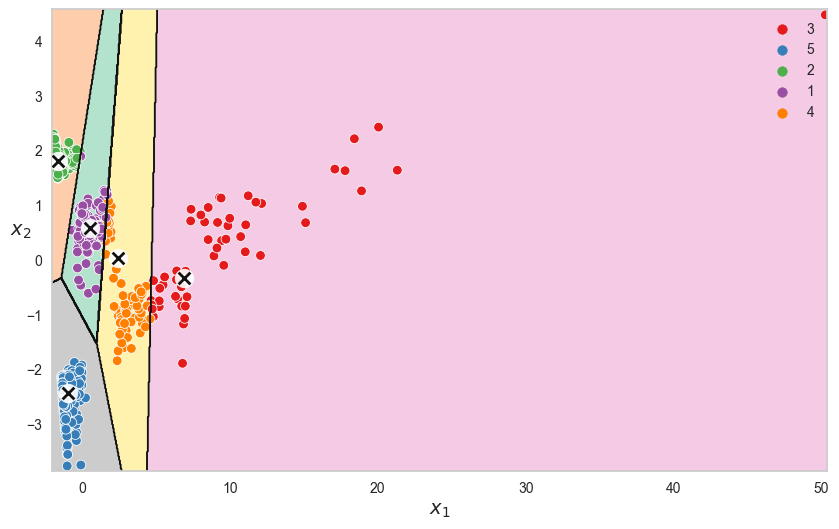

In [28]:
plt.figure(figsize=(10, 6))
plot_decision_boundaries(fuzz_pcv, dota_pc)
plt.show()

As you can see, the fuzzy model placed all points in one of five clusters. The 'X' marks the centroid for that cluster - the dark lines, the decision boundaries. The legend shows when color belongs to which cluster. For example, cluster 5 is red.

However, as opposed to Lab 1, we see a lot more points hugging or straddling decision boundaries.

Now, let's take our visualization a step further by adding the SKillLevel column as we did in Lab 1.

First we need to work on the SkillLevel data a little and then create the combined array.

In [29]:
dota_skill_level = np.append(dota_pc, dota_level, axis=1)
dota_skill_level

array([[5.491255978262059, -0.4584610441535672, 'B'],
       [-0.4322629655003522, -2.0867127628457993, 'B'],
       [-1.6532432257255314, 1.5612544115751859, 'N'],
       ...,
       [-1.7690824893303527, 1.966696761311769, 'N'],
       [0.9513319010861859, -0.5359993530508567, 'B'],
       [-1.0726814108037634, -3.095829712338153, 'N']], dtype=object)

Now, we have three columns for each row. We can use that third column to add information to the same chart above.

The code to create the chart is repeated, again with slight tweaks.

In [33]:
def plot_data(X, labels, levels):
    sns.scatterplot(X, x=X[:,0], y=X[:, 1], hue=labels, legend='full',palette="Set1", style=levels[:, 2])

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, levels, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X[:, 0:2].min(axis=0) - 0.1
    maxs = X[:, 0:2].max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    label_map = {0:'1', 1:'2', 2:'3', 3:'4', 4:'5'}
    labels =  [label_map[a] for a in clusterer.predict(X)]
    
    plot_data(X, labels, levels)
    if show_centroids:
        plot_centroids(clusterer.centers)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

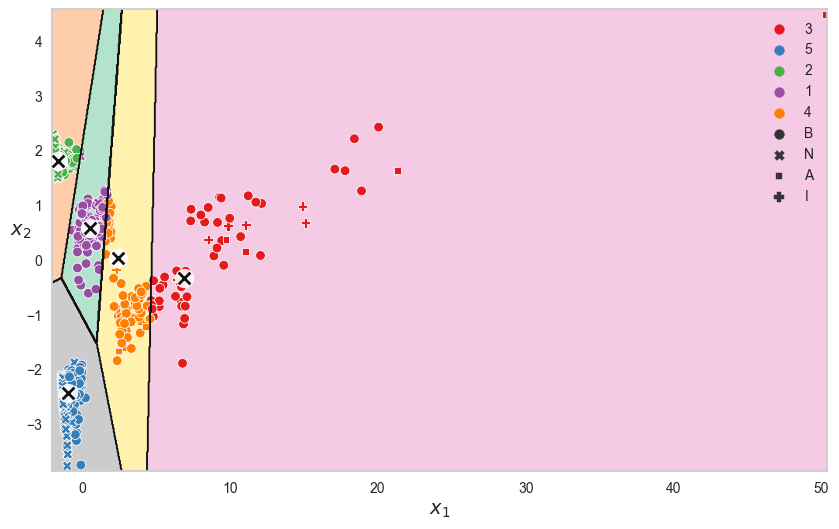

In [34]:
plt.figure(figsize=(10, 6))
plot_decision_boundaries(fuzz_pcv, dota_pc, dota_skill_level)
plt.show()

Now, we have even richer data! The legend need a little interpretation: The colors show which cluster the point was assigned to and the shape of the point shows which SkillLevel the point was assigned to originally.

It is apparent that there is a lot of mixture of SkillLevel throughout the clusters. This could mean many things, including mistakenly assigned SkillLevels.

However, with this amount of scattering, there is probably an issue with our analysis.